(un-lab)=
# Unsupervised learning

In [1]:
import numpy as np              # numeric
import matplotlib.pyplot as plt # plotting
import statistics as st         # statistics
from IPython.display import display, Image # display imported graphics

In [2]:
import os.path 

isdir = os.path.isdir('lib_nn') # check whether 'lib_nn' exists

if not isdir:
   !git clone https://github.com/bronwojtek/lib_nn.git # cloning the library from github

import sys                     
sys.path.append('./lib_nn') 

from neural import *            # importing my library package

Invoking __init__.py for neural


```{admonition} Motto
:class: tip

*teachers! leave those kids alone!*

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (Pink Floyd, Another Brick In The Wall)
                             
```

Supervised learning, discussed in previous lectures, needs a teacher or a training sample with labels, where we know **a priori** characteristics of the data (e.g., as in one of our examples, whether a given point is inside or outside the circle).

However, this is quite a special situation, because most often the data that we encounter do not have preassigned labels and "are what they are". Also, from the neurobiological or methodological point of view, we learn many facts and activities "on an ongoing basis", classifying and then recognizing them, whilst the process goes on without any external supervision or labels floating around.

Imagine an alien botanist who enters a meadow and encounters various species of flowers. He has no idea what they are and what to expect at all, as he has no prior knowledge on earthly matters. After finding the first flower, he records its features: color, size, number of petals, scent, etc. He goes on, finds a different flower, records its features, and so on and on with subsequent flowers. At some point, however, he finds a flower that he already had met. More precisely, its features are close, though not identical (the size may easily differ somewhat, so the color, etc.), to the previous instance. Hence he concludes that it belongs to the same category. The exploration goes on, and new flowers either start a new category, of join one already present. At the end of his quest, he has a catalog of flowers and now he can assign names (labels) to each species: corn poppy, bluebottle, mullein,...  These labels, or names, are useful in sharing the knowledge with others, as they summarize, so to speak, the features of the flower. Note, however, that these labels have actually never been used in the meadow exploration (learning) process.


Formally, the described problem of **unsupervised learning** is related to data classification (division into categories, or **clusters**, i.e. subsets of the sample where the suitably defined distances between individual data are small, smaller than the assumed distances between clusters). Colloquially speaking, we are looking for similarities between individual data points and try to divide the sample into groups of similar objects.

## Clusters of points

Here is our simplified version of the alien botanist exploration.

Consider points on the plane that are randomly generated. Their distribution is not homogeneous, but is concentrated in four clusters: A, B, C, and D. For example, we can set appropriate limits for the coordinates $x_1$ and $x_2$ when randomly generating points of a given category. We use the numpy **random.uniform(a,b)** function, giving a uniformly distributed number between a and b: 

In [3]:
def pA():
    return [np.random.uniform(.75, .95), np.random.uniform(.7, .9)] 

def pB():
    return [np.random.uniform(.4, .6), np.random.uniform(.6, .75)] 

def pC():
    return [np.random.uniform(.1, .3), np.random.uniform(.4, .5)] 

def pD():
    return [np.random.uniform(.7, .9), np.random.uniform(0, .2)] 

Let us create data samples with a few points from each category:

In [4]:
samA=np.array([pA() for _ in range(10)])
samB=np.array([pB() for _ in range(7)])
samC=np.array([pC() for _ in range(9)])
samD=np.array([pD() for _ in range(11)])

Our data looks like this:

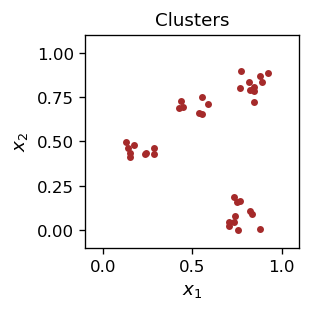

In [5]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Clusters",fontsize=11) 

plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c='brown', s=10)
plt.scatter(samB[:,0],samB[:,1],c='brown', s=10)
plt.scatter(samC[:,0],samC[:,1],c='brown', s=10)
plt.scatter(samD[:,0],samD[:,1],c='brown', s=10)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

If we show the above picture to someone, This the person will undoubtedly state that there are four clusters. But what algorithm is being used to determine this? We will construct such an algorithm shortly and will be able to carry out clusterization. For the moment, let us jump ahead and assume we **know** what the clusters are. Clearly, in our example the clusters are well defined, i.e. visibly separated from each other. 

One can represent clusters with **representative points** that lie somewhere within the cluster. For example, one could take an item belonging to a given cluster as its representative, or for each cluster one can evaluate the mean position of its points and use it as a representative point:

In [6]:
rA=[st.mean(samA[:,0]),st.mean(samA[:,1])]
rB=[st.mean(samB[:,0]),st.mean(samB[:,1])]
rC=[st.mean(samC[:,0]),st.mean(samC[:,1])]
rD=[st.mean(samD[:,0]),st.mean(samD[:,1])]

(we have used the **statistics** module to evaluate the mean). We append thus defined characteristic points to our graphics. For visual convenience, we assign a color for each category (after having the clusters, we may assign labels, and the color here serves precisely this purpose).

In [7]:
col=['red','blue','green','magenta']

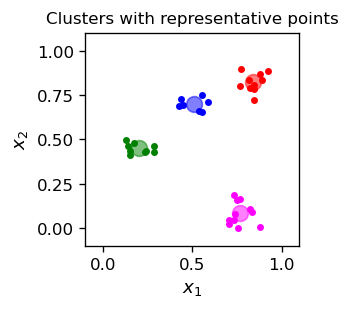

In [8]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Clusters with representative points",fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

plt.scatter(samA[:,0],samA[:,1],c=col[0], s=10)
plt.scatter(samB[:,0],samB[:,1],c=col[1], s=10)
plt.scatter(samC[:,0],samC[:,1],c=col[2], s=10)
plt.scatter(samD[:,0],samD[:,1],c=col[3], s=10)

plt.scatter(rA[0],rA[1],c=col[0], s=90, alpha=0.5)
plt.scatter(rB[0],rB[1],c=col[1], s=90, alpha=0.5)
plt.scatter(rC[0],rC[1],c=col[2], s=90, alpha=0.5)
plt.scatter(rD[0],rD[1],c=col[3], s=90, alpha=0.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

(vor_lab)=
## [Voronoi areas](https://en.wikipedia.org/wiki/Voronoi_diagram)

Having the situation as in the figure above, i.e. with the representative points determined, we can divide the entire plane into areas according to the following Voronoi criterion, which is a simple geometric notion:

```{admonition} Voronoi areas
:class: important

Consider a metric space in which there are a number of representative points (the Voronoi points) $R$. For a given point $P$ one determines the distances to all $R$. If there is a strict minimum among these distances (the closest point $R_m$), then by definition $P$ belongs to the Voronoi area of $R_m$. If there is no strict minimum, then $P$ belongs to a boundary between some Voronoi regions. The construction divides the whole space into Voronoi areas and their boundaries.
```

Returning to our example, let us then define the color of a point P in our square as the color of the nearest representative point. To do it, we first need (the square of) the distance function (here Euclidean) between two points in 2-dim. space:

In [9]:
def eucl(p1,p2): # square of the Euclidean distance
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2

Then, with **np.argmin**, we find the nearest representative point and determine its color:

In [10]:
def col_char(p):
    dist=[eucl(p,rA),eucl(p,rB),eucl(p,rC),eucl(p,rD)] # array of distances
    ind_min = np.argmin(dist)                          # index of the nearest point
    return col[ind_min]                                # color of the nearest point

for instance

In [11]:
col_char([.5,.5])

'blue'

The result of running this coloring for points in our square (we take here a sufficiently dense sample of 70\tims 70$ points) is its following division into the Voronoi areas:

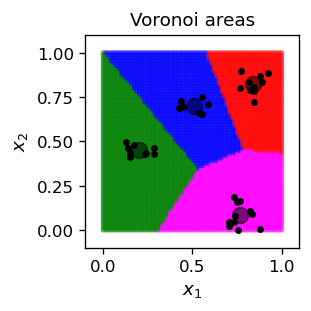

In [12]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Voronoi areas",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)

for x1 in np.linspace(0,1,70): # 70 points in x
    for x2 in np.linspace(0,1,70): # 70 points in y
        plt.scatter(x1,x2,c=col_char([x1,x2]), s=10, alpha=0.6, edgecolors='none')

plt.scatter(samA[:,0],samA[:,1],c='black', s=10)
plt.scatter(samB[:,0],samB[:,1],c='black', s=10)
plt.scatter(samC[:,0],samC[:,1],c='black', s=10)
plt.scatter(samD[:,0],samD[:,1],c='black', s=10)

plt.scatter(rA[0],rA[1],c='black', s=90, alpha=.5)
plt.scatter(rB[0],rB[1],c='black', s=90, alpha=.5)
plt.scatter(rC[0],rC[1],c='black', s=90, alpha=.5)
plt.scatter(rD[0],rD[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

It is easy to prove that the boundaries between neighboring areas are straight lines.

```{note}

A practical message here is that once we have determined the characteristic points, we can use Voronoi's criterion for a classification of data.
```

## Naive clusterization

Now we go back to the alien botanist's problem:  imagine we have our sample, but we know nothing about how its points were generated (we do not have any labels A, B, C, D, nor colors of the points). Moreover, the data is mixed, i.e., the data points appear in a random order. So we merge our points with **np.concatenate**:

In [13]:
alls=np.concatenate((samA, samB, samC, samD))

and shuffle them with **np.random.shuffle**:

In [14]:
np.random.shuffle(alls)

The data visualization looks as in the first plot of this chapter.

We now want to somehow create representative points, but a priori we don't know where they should be, or even how many of them there are. Very different strategies are possible here. Their common feature is that the position of the representative points is updated as the sample data is processed.

Let us start with just one representative point, $\vec{R}$. Not very ambitious, but in the end we will at least know some mean characteristics of the sample. The initial position is $ R=(R_1, R_2) $, a two dimensional vector in $[0,1]\times [0,1]$. After reading a data point $P$ with coordinates $ (x_1 ^ P, x_2 ^ P) $, $R$ changes as follows:

$$ (R_1, R_2) \to (R_1, R_2) + \varepsilon (x_1 ^P-R_1, x_2 ^P-R_2), $$

or in the vector notation

$$ \vec {R} \to \vec {R} + \varepsilon (\vec {x}^P - \vec {R}). $$

The step is repeated for all the points of the sample, and then many such rounds may be carried out. As in the previous chapters, $ \varepsilon $ is the learning rate that (preferably) decreases
as the algorithm proceeds. The above formula realizes the "snapping" of the point $\vec{R}$ by the data point $\vec{P}$.

The following code implements the above prescription:

In [15]:
R=np.array([np.random.random(),np.random.random()]) # initial location

print("initial location:")
print(np.round(R,3))
print("round   location")

eps=.5                         # initial learning speed

for j in range(50):            # rounds
    eps=0.85*eps               # decrease the learning speed 
    np.random.shuffle(alls)    # reshuffle the sample
    for i in range(len(alls)): # loop over points of the whole sample
        R+=eps*(alls[i]-R)     # update/learning
    if j%5==4: print(j+1, "    ",np.round(R,3))  # print every 5th step

initial location:
[0.42  0.084]
round   location
5      [0.653 0.655]
10      [0.658 0.385]
15      [0.603 0.462]
20      [0.594 0.484]
25      [0.598 0.486]
30      [0.598 0.487]
35      [0.599 0.488]
40      [0.599 0.488]
45      [0.599 0.488]
50      [0.599 0.488]


We can see that the position of the characteristic point converges. Actually, it becomes very close to the mean location of all the points of the sample, 

In [16]:
R_mean=[st.mean(alls[:,0]),st.mean(alls[:,1])]
print(np.round(R_mean,3))

[0.599 0.488]


We have decided a priori to have just one category, and here is our plot of the result for the characteristic point, indicated with a gray blob:

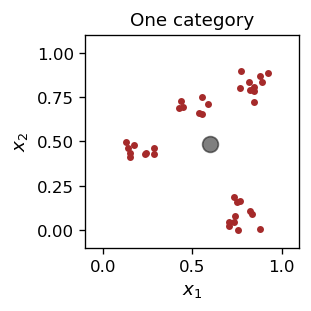

In [17]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("One category",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R[0],R[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

One is, of course, not satisfied with the above (things are not classified with one category), so let us try to generalize the algorithm for the case of several ($ n_R> $ 1) representative points.

- We initialize randomly representative vectors $ \vec{R}^i $, $i = 1, \dots, n_R $.

- Round: We take the sample points P one by one and update only the **closest** representative point $R^m$ to the point P in a given step:

$$ \vec{R}^m \to \vec{R}^m + \varepsilon (\vec{x} - \vec{R}^m). $$

- The position of the other representative points remains unchanged. This strategy is called **winner-take-all**.

- We repeat the rounds, reducing the learning speed $ \varepsilon $ each time, until we are happy with the result.

```{important}

The **winner-take-all** strategy is an important concept in the ANN training. The competing neurons in a layer fight for the "reward", and the one that wins, takes it all (its weighs get updated), while the losers get nothing.
```

Let us then consider two representative points that we initialize randomly:

In [18]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])

Next, we carry out the above algorithm. For each data point we find the nearest representative point out of the two, and update only the winner:

In [19]:
print("initial locations:")
print(np.round(R1,3), np.round(R2,3))
print("rounds  locations")

eps=.5

for j in range(40):             
    eps=0.85*eps
    np.random.shuffle(alls) 
    for i in range(len(alls)):
        p=alls[i]   
        dist=[func.eucl(p,R1), func.eucl(p,R2)] # squares of distances
        ind_min = np.argmin(dist)               # index of the minimum
        if ind_min==0:         # if R1 closer to the new data point
            R1+=eps*(p-R1)     # update R1                
        else:                  # if R2 closer ... 
            R2+=eps*(p-R2)     # update R2       

    if j%5==4: print(j+1,"    ", np.round(R1,3), np.round(R2,3))  

initial locations:
[0.489 0.494] [0.814 0.666]
rounds  locations
5      [0.749 0.097] [0.409 0.608]
10      [0.764 0.085] [0.469 0.641]
15      [0.765 0.084] [0.526 0.657]
20      [0.766 0.083] [0.523 0.657]
25      [0.766 0.083] [0.525 0.659]
30      [0.766 0.083] [0.527 0.66 ]
35      [0.766 0.082] [0.527 0.66 ]
40      [0.767 0.082] [0.527 0.66 ]


The result is this:

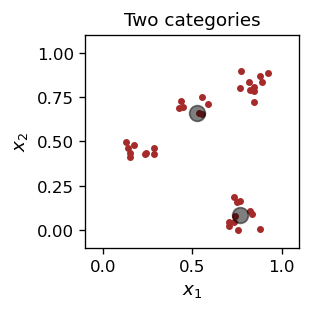

In [20]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Two categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

One of the characteristic points "specializes" in the lower right cluster, and the other in the remaining points.

Next, we continue, completely analogously, with four representative points.

initial locations:
[0.559 0.582] [0.052 0.872] [0.812 0.978] [0.624 0.158]
rounds   locations
[0.186 0.457] [0.052 0.872] [0.755 0.782] [0.766 0.095]
[0.255 0.507] [0.052 0.872] [0.76  0.779] [0.768 0.079]
[0.252 0.507] [0.052 0.872] [0.767 0.789] [0.768 0.084]
[0.255 0.51 ] [0.052 0.872] [0.764 0.789] [0.767 0.082]
[0.256 0.511] [0.052 0.872] [0.761 0.787] [0.766 0.082]
[0.257 0.511] [0.052 0.872] [0.761 0.787] [0.766 0.082]
[0.257 0.512] [0.052 0.872] [0.761 0.787] [0.766 0.082]
[0.257 0.512] [0.052 0.872] [0.761 0.787] [0.766 0.082]


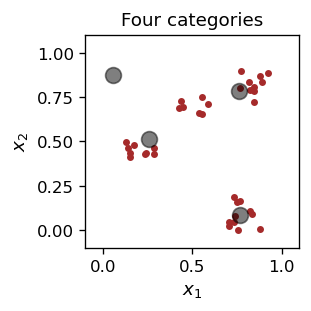

In [21]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])
R3=np.array([np.random.random(), np.random.random()])
R4=np.array([np.random.random(), np.random.random()])


print("initial locations:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   
print("rounds   locations")

eps=.5

for j in range(40):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[func.eucl(p,R1), func.eucl(p,R2), func.eucl(p,R3), func.eucl(p,R4)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        else:
            R4+=eps*(p-R4)             

    if j%5==4: print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3))   

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Four categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)
plt.scatter(R3[0],R3[1],c='black', s=90, alpha=.5)
plt.scatter(R4[0],R4[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

The result for two different initial conditions of the characteristic points is 
shown in {numref}`4p-fig`.

:::{figure-md} 4p-fig

<img src="images/cl4_2.png" width="500px">

Left: proper characteristic points. Right: one "dead body".
:::

We notice that the procedure does not always give the "correct"/expected answer. Quite often one of the representative points is not updated at all and becomes the so-called **dead body**. This is because the other representative points always win, i.e. one of them is always closer to each data point of the sample than the "corpse". Certainly, this is an unsatisfactory situation.

initial locations:
[0.894 0.376] [0.182 0.876] [0.052 0.799] [0.305 0.737] [0.555 0.71 ]
rounds   locations
[0.755 0.089] [0.497 0.693] [0.052 0.799] [0.188 0.45 ] [0.84  0.814]
[0.769 0.075] [0.509 0.699] [0.052 0.799] [0.2   0.447] [0.846 0.824]
[0.765 0.082] [0.506 0.697] [0.052 0.799] [0.199 0.449] [0.841 0.825]
[0.766 0.082] [0.507 0.697] [0.052 0.799] [0.199 0.449] [0.841 0.824]
[0.766 0.083] [0.506 0.697] [0.052 0.799] [0.199 0.449] [0.841 0.824]
[0.766 0.082] [0.506 0.697] [0.052 0.799] [0.199 0.449] [0.841 0.824]


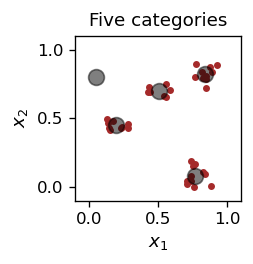

In [22]:
R1=np.array([np.random.random(), np.random.random()])
R2=np.array([np.random.random(), np.random.random()])
R3=np.array([np.random.random(), np.random.random()])
R4=np.array([np.random.random(), np.random.random()])
R5=np.array([np.random.random(), np.random.random()])

print("initial locations:")
print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   
print("rounds   locations")


eps=.5

for j in range(30):
    eps=0.85*eps
    np.random.shuffle(alls)
    for i in range(len(alls)):
        p=alls[i]
        dist=[func.eucl(p,R1), func.eucl(p,R2), func.eucl(p,R3), func.eucl(p,R4), func.eucl(p,R5)]
        ind_min = np.argmin(dist)
        if ind_min==0:
            R1+=eps*(p-R1)
        elif ind_min==1:
            R2+=eps*(p-R2)  
        elif ind_min==2:
            R3+=eps*(p-R3)  
        elif ind_min==3:
            R4+=eps*(p-R4)  
        else:
            R5+=eps*(p-R5)             

    if j%5==4: 
        print(np.round(R1,3), np.round(R2,3), np.round(R3,3), np.round(R4,3), np.round(R5,3))   

plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("Five categories",fontsize=11) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
       
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

plt.scatter(R1[0],R1[1],c='black', s=90, alpha=.5)
plt.scatter(R2[0],R2[1],c='black', s=90, alpha=.5)
plt.scatter(R3[0],R3[1],c='black', s=90, alpha=.5)
plt.scatter(R4[0],R4[1],c='black', s=90, alpha=.5)
plt.scatter(R5[0],R5[1],c='black', s=90, alpha=.5)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)

plt.tight_layout()
plt.show()

When we set up five characteristic points, depending on the random initialization, several situation may occur, as shown in {numref}`5p-fig`. Sometimes a cluster is split into two smaller ones, sometimes dead bodies occur.

:::{figure-md} 5p-fig

<img src="images/cl5.jpg" width="870px">

From left to right: 5 characteristic points with one cluster split into two, with another cluster split into two, one dead body, and two dead bodies.
:::

Enforcing more representative points leads to the formation of dead bodies even more often. Of course, we may disregard them, but the example shows that the current strategy is highly problematic and we need something better. 

## Clustering scale

In the previous section we were trying to guess from the outset how many clusters there are in the data. This led to problems, as usually we do not even know how many clusters there are. Actually, up to now we have not defined what precisely a cluster is, and were using some intuition only. This intuition told us that the points in the same cluster must be close to one another, or close to a characteristic point, but how close? Actually, the definition must involve a **scale** (a characteristic distance) telling us "how close is close". For instance, in our example we may take a scale of about 0.2, where there are 4 clusters, but we may take a smaller scale and resolve the bigger clusters into smaller ones, as in two left panels of {numref}`5p-fig`.


```{admonition} Definition of cluster
:class: note

A cluster of scale $d$ associated with a characteristic point $R$ is a set of data points $P$, whose distance from $R$ is less than $d$, whereas the distance from other characteristic points is $\ge d$. The characteristic points must be selected in such a way that each data point belongs to a cluster, and no characteristic point is a dead body (i.e., its cluster must contain at least one data point).
```

Various strategies can be used to implement this prescription. We use here the **dynamical clusterization**, where a new cluster/representative point is created whenever an encountered data point is farther than $d$ from any characteristic point defined up to now.   

```{admonition} Dynamical clusterization
:class: important

0. Set the clustering scale $d$ and the initial learning speed $\varepsilon$. Shuffle the sample.

1. Read the first data point $P_1$ and set the first characteristic point $R^1=P_1$. Add it to an array $R$ of all characteristic points. Mark $P_1$ as belonging to cluster $1$. 

2. Read the next data points $P$. If the distance of $P$ to the **closest** characteristic point, $R^m$, is $\le d$, then 
    - mark $P$ as belonging to cluster $m$. 
    - move $R^m$ towards $P$ with the learning speed $\varepsilon$.     
Otherwise, add to $R$ a new characteristic point at the location of point $P$. 

3. Repeat from $2.$ until all the data points are processed. 

4. Repeat from $2.$ in a number of rounds, decreasing each time $\varepsilon$. The result is a division of the sample into a number of clusters, and the location of corresponding characteristic points. The result may depend on the random reshuffling, hence does not have to be the same when the procedure is repeated.
```

A Python implementation, finding dynamically the representative points, is following:

In [23]:
d=0.2   # clustering scale
eps=0.5 # initial learning speed

for r in range(20):               # rounds
    eps=0.85*eps                  # decrease the learning speed 
    np.random.shuffle(alls)       # shuffle the sample
    if r==0:                      # in the first round
        R=np.array([alls[0]])     # R - array of representative points
                                  # initialized to the first data point
    for i in range(len(alls)):    # loop over the sample points
        p=alls[i]                 # new data point
        dist=[func.eucl(p,R[k]) for k in range(len(R))] 
         # array of squares of distances of p from the current repr. points in R
        ind_min = np.argmin(dist) # index of the closest repr. point
        if dist[ind_min] > d*d:   # if its distance square > d*d
                                  # dynamical creation of a new category
            R=np.append(R, [p], axis=0)    # add new repr. point to R
        else:   
            R[ind_min]+=eps*(p-R[ind_min]) # otherwise, apdate the "old" repr. point

print("Number of representative points: ",len(R))

Number of representative points:  4


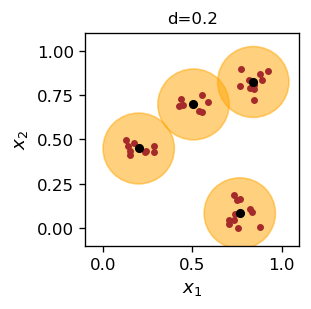

In [24]:
fig=plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("d="+str(d),fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
    
# drawing the circles
for k in range(len(R)):
    circ=plt.Circle((R[k][0],R[k][1]), radius=d, color='orange', fill=True, alpha=0.5)
    plt.gca().add_artist(circ)

# the sample points         
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10 ,zorder=5)

# characteristic points
for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20, zorder=10)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

The outcome of the algorithm for various values of the clustering scale $d$ is shown in {numref}`dyn-fig`. At very low values of $d$, smaller than the minimum separation between the points, there are as many clusters as the data points. Then, as we increase $d$, the number of clusters decreases. At very large $d$, of the order of the span of the whole sample, there is only one cluster.

:::{figure-md} dyn-fig

<img src="images/cd.jpg" width="770px">

Dynamical clustering for various values of the scale $d$.
:::

Certainly, an algorithm will not tell us which clustering scale to use. The proper value depends on the nature of the problem. Recall our botanist. If he used a very small $d$, he would get as many categories as there are flowers in the meadow, as all flowers, even of the same species, are slightly different from one another. That would be useless. On the other extreme, if his $d$ is too large, then the classification is too crude. Something in between is just right!

```{admonition} Labels
:class: note

After forming the clusters, we may assign them **labels** for convenience. They are not used in the learning (cluster formation) process.
```

Having determined the clusters, we have a **classifier**. We may use it in a two-fold way:
   - continue the dynamical update as new data are encountered, or
   - "close" it, and see where the new data falls in.
   
In the first case, we assign a corresponding cluster label to the new data point (our botanist knows what new flower he found), or initiate a new category if the point does not belong to any of the existing clusters. This is just a continuation of the dynamical algorithm described above for new incoming data

In the latter case (we bought the ready and closed botanist's catalog), a data point may 
   - belong to a cluster (we know its label), 
   - fall outside of any cluster, then we just do not know what it is, or 
   - fall into an overlapping region of two or more clusters (cf. {numref}`dyn-fig`, where we only get "partial" or ambiguous classification.
   
Alternatively, we can use the Voronoi areas classification to get rid of the ambiguity.   

### Interpretation via steepest descent

Let us denote a given cluster with $C_i$, $i = 1, ..., n$, where $ n $ is the total number of clusters. The sum of the squared distances of data points in $ C_i $ to its representative point $ R ^ i $ is

$$
\sum_{P \in C_i} | \vec{R}^i- \vec{x}^P|^2.
$$

Summing up over all clusters, we obtain a function analogous to the previously discussed error function:

$$E (\{R \}) = \sum_{i = 1}^ n \sum_ {P \in C_i} |\vec{R}^i- \vec{x}^P |^2 .$$

Its derivative with respect to $ \vec{R}_i $ is

$$ \frac{\partial E (\{R \})}{\partial \vec{R}^i}
= 2 \sum_{P \in C_i} (\vec{R}^i- \vec{x}^P). $$

The steepest descent method results **exactly** in the recipe used in the 
dynamic clusterization algorithm presented above, i.e.

$$ \vec{R} \to \vec{R} - \varepsilon (\vec{R} - \vec {x}^P). $$

To summarize, the algorithm used here actually involves the steepest descent method for the function $ E (\{R \})$, as discussed in the previous lectures. 

```{note}
Note, however, that the minimization used in the present algorithms also takes into account different combinatorial divisions of points into clusters. In particular, a given data point may change its cluster assignment during the execution of the algorithm. This happens when its closest representative point changes.
```

(inn-sec)=
## Interpretation via neural networks

We shall now interpret the unsupervised learning algorithm used above with the winner-take-all strategy in the neural network language. We have the following sample network:

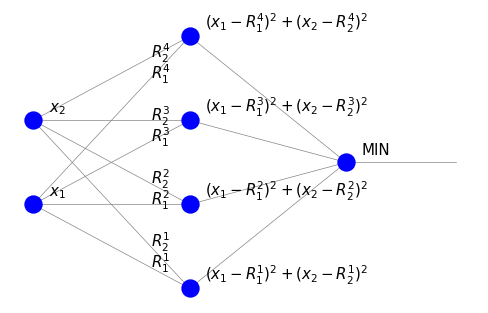

In [25]:
def plot_net_lab_0(n_war, wagi, x):
    li_war=len(n_war)
    plt.figure(figsize=(5,3),dpi=120) 

    for i in range(li_war): 
        for j in range(n_war[i]):  
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue',zorder=10) 
            lab=x[i][j]
            plt.text(i+0.1, j-n_war[i]/2+0.1, lab, fontsize=9)
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]):
                plt.plot([i,i+1],[j-n_war[i]/2,k-n_war[i+1]/2],c='gray',linewidth=0.4)
                plt.text(i+0.75, 0.25*(j-n_war[i]/2)+0.75*(k-n_war[i+1]/2), 
                         wagi[i+1][j][k], fontsize=9)
                
    # the last edge on the right
    for j in range(n_war[li_war-1]):
        plt.plot([li_war-1,li_war-1+0.7],
                 [j-(n_war[li_war-1])/2,j-(n_war[li_war-1])/2],c='gray',linewidth=0.4)
            

    plt.axis("off")
    plt.show()

plt.show(plot_net_lab_0([2,4,1],
             {1: [["$R_1^1$", "$R_1^2$", "$R_1^3$", "$R_1^4$"], 
                  ["$R_2^1$", "$R_2^2$", "$R_2^3$", "$R_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$"]), 
              1: np.array(["$(x_1-R_1^1)^2+(x_2-R_2^1)^2$",
                           "$(x_1-R_1^2)^2+(x_2-R_2^2)^2$",
                           "$(x_1-R_1^3)^2+(x_2-R_2^3)^2$", 
                           "$(x_1-R_1^4)^2+(x_2-R_2^4)^2$"]), 
              2: np.array(["MIN"])}))

It consists of four neurons in the intermediate neuron layer, each corresponding to one characteristic point $\vec{R}^i$. The weights are the coordinates of $\vec{R}^i$. There is one node in the output layer. We note significant differences from the perceptron discussed earlier.

- There are no threshold nodes.

- In the intermediate layer, the signal equals the distance squared of the input from the corresponding characteristic point. It is not a weighted sum.

- The node in the last layer (MIN) indicates in which neuron of the intermediate layer the signal is the smallest, i.e., where we have the shortest distance. Hence it works as a control unit selecting the minimum.

During (unsupervised) learning, an input point P "attracts" the closest characteristic point, whose weights are updated towards the coordinates of P.

The application of the above network classifies the point with coordinates $(x_1, x_2)$, assigning it the index of the closest representative point of a given category (here it is the number 1, 2, 3, or 4).

### Representation with spherical coordinates

Even with our vast "mathematical liberty", calling the above system a neural network would be quite abusive, as it seems very far away from any neurobiological pattern. In particular, the use of a (non-linear) signal of the form $\left(\vec{R}^i-\vec{x}\right)^2$ contrasts with the perceptron, where the signal entering the neurons is a (linear) weighted sum of inputs, i.e.

$$ s ^ i = x_1 w_1 ^ i + x_2 w_2 ^ i + ... + w_1 ^ m x_m = \vec {x} \cdot \vec {w} ^ i. $$

We can alter our problem with a simple geometric construction/trick to make it more similar to the perceptron principle. For this purpose we introduce a (spurious) third coordinate defined as

$$ x_3 = \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2}, $$

where $ r $ is chosen such that for all data points $ r ^ 2 \ge x_1 ^ 2 + x_2 ^ 2 $.
From construction, $ \vec {x} \cdot \vec {x} = x_1 ^ 2 + x_2 ^ 2 + x_3 ^ 2 = r ^ 2 $, so the data points lie on the hemisphere ($ x_3 \ge 0 $) of radius $ r $. Similarly, for the representative points we introduce:

$$ w_1 ^ i = R_1 ^ i,  \; w_2 ^ i = R_2 ^ i,  \; 
w_3 ^ i = \sqrt {r ^ 2-(R_1 ^i)^2 -(R_2 ^i)^2}. $$

It is geometrically obvious that two points in a plane are close to each other if and only if their extensions to the hemisphere are close. We support this statement with a simple calculation:

The dot product of two points $ \vec {x} $ and $ \vec {y} $ on a hemisphere can be written as

$$ \vec {x} \cdot \vec {y} = x_1 y_1 + x_2 y_2 + \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2} \sqrt {r ^ 2-y_1 ^ 2-y_2 ^ 2}. $$

For simplicity, let us consider a situation when $ x_1 ^ 2 + x_2 ^ 2 \ll r ^ 2 $ and $ y_1 ^ 2 + y_2 ^ 2 \ll r ^ 2 $, i.e. both points lie near the pole of the hemisphere. Using your knowledge of mathematical analysis

$$ \sqrt{r^2-a^2} \simeq r - \frac{a^2}{2r},  \;\;\;a \ll r, $$ 

hence

$\vec{x} \cdot \vec{y} \simeq x_1 y_1 + x_2 y_2 + \left( r -\frac{x_1^2+x_2^2}{2r} \right) \left( r -\frac{y_1^2+y_2^2}{2r} \right) \\ 
\;\;\;\simeq r^2 - \frac{1}{2} (x_1^2+x_2^2 +y_1^2+y_2^2) + x_1 y_1+x_2 y_2 \\ 
\;\;\; = r^2 - \frac{1}{2}[ (x_1-x_2)^2 +(y_1-y_2)^2]$.

It equals (for points close to the pole) the constant $ r ^ 2 $ minus half the square of the distance between the points $ (x_1, x_2) $ and $ (y_1, y_2) $ on the plane! It then follows that instead of finding a minimum distance for points on the plane, as in the previous algorithm, we can find a maximum scalar product for their 3-dim. extensions to a hemisphere.

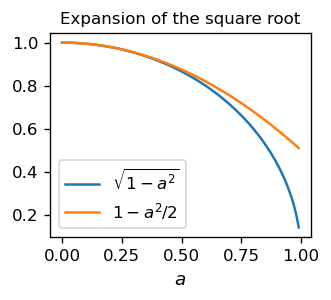

In [26]:
plt.figure(figsize=(2.8,2.2),dpi=120)
plt.title("Expansion of the square root",fontsize=10) 

s=np.arange(0,1,.01)
st=np.sqrt(1-s**2)
se=1-s**2/2

plt.plot(s,st)
plt.plot(s,se)

plt.legend(('$\sqrt{1-a^2}$','$1-a^2/2$'),fontsize=10)
plt.xlabel('$a$',fontsize=11)
plt.show()

With the extension of the data to a hemisphere, the appropriate neural network can be viewed as follows:

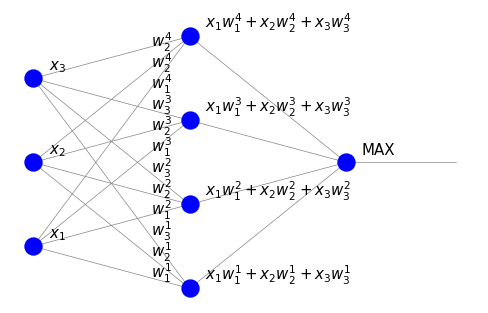

In [27]:
plt.show(plot_net_lab_0([3,4,1],
             {1: [["$w_1^1$", "$w_1^2$", "$w_1^3$", "$w_1^4$"], 
                  ["$w_2^1$", "$w_2^2$", "$w_2^3$", "$w_2^4$"],
                  ["$w_3^1$", "$w_3^2$", "$w_3^3$", "$w_2^4$"]], 
              2: [[""], [""], [""],[""]]} ,
             {0: np.array(["$x_1$","$x_2$","$x_3$"]), 
              1: np.array(["$x_1 w_1^1+x_2 w_2^1+x_3 w_3^1$",
                           "$x_1 w_1^2+x_2 w_2^2+x_3 w_3^2$",
                           "$x_1 w_1^3+x_2 w_2^3+x_3 w_3^3$", 
                           "$x_1 w_1^4+x_2 w_2^4+x_3 w_3^4$"]), 
              2: np.array(["MAX"])}))

Thanks to our efforts, the signal in the intermediate layer is now just a dot product of the input and the weights, as it should be in an artificial neuron. The unit in the last layer (MAX) indicates where the dot product is largest. 

This MAX unit is still problematic to interpret within our present framework. Actually, it is possible, but requires going beyond feed-forward type networks. When the neurons in the layer can communicate (recurrent [Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network)), they can compete, and with proper feed-back it is possible to enforce the winner-take-all mechanism. We discuss these aspects in section {ref}`lat-lab'.

```{admonition} Hebbian rule
:class: important

On the conceptual side, we touch upon a very important and intuitive principle in biological neural networks, known as the [Hebbian rule](https://en.wikipedia.org/wiki/Hebbian_theory). Essentially, it applies the truth "What is being used, gets stronger" to synaptic connections. A repeated use of a connection makes it stronger.
```

In our formulation, if a signal passes through a given connection, its weight changes accordingly, while other connections remain the same. The process takes place in an unsupervised manner and its implementation is biologically well motivated. 

```{note}

On the other hand, it is difficult to find a biological justification for the backprop supervised learning, where all weights are updated, also in layers very distant from the output. According to many researchers, it is rather a mathematical concept (but nevertheless extremely useful).
```

### Scalar product maximization

Now the algorithm becomes as as follows:

- Extend the points from the sample with the third coordinate, $ x_3 = \sqrt {r ^ 2-x_1 ^ 2-x_2 ^ 2} $, choosing appropriately large $ r $, such that $ r ^ 2> x_1 ^ 2 + x_2 ^ 2 $ for all sample points.

- Initialize the weights such that $ \vec {w} _i \cdot \vec {w} _i = r ^ 2 $.

Then loop over the data points:

- Find the neuron in the intermediate layer for which the dot product $ x \cdot \vec {w} _i $ is the largest. Change the weights of this neuron according to the recipe

$$ \vec {w} ^ i \to \vec {w} ^ i + \varepsilon (\vec {x} - \vec {w} ^ i). $$

- Renormalize the updated weight vector $ \vec {w_i} $ such that $ \vec {w} _i \cdot \vec {w} _i = r ^ 2 $:

$$ \vec {w} ^ i \to \vec {w} ^ i \frac {r} {\sqrt {\vec {w} _i \cdot \vec {w} _i}}. $$

The remaining steps of the algorithm, such as determining the initial positions of the representative points, their dynamic creation as they encounter successive data points, etc., remain exactly as in the previously discussed procedure.

The generalization for $ n $ dimensions is obvious: we enter an additional coordinate

$$ x_ {n + 1} = \sqrt {r ^ 2 - x_1 ^ 2 -...- x_n ^ 2},$$

hence we have a point on the hyper-hemisphere $ x_1 ^ 2 + \dots + x_n ^ 2 + x_ {n + 1} ^ 2 = r ^ 2 $,  $x_ {n + 1} >0$.

In Python:

In [28]:
d=0.25
eps=.5

rad=2    # radius of the hypersphere

for r in range(25):
    eps=0.85*eps
    np.random.shuffle(alls)
    if r==0:
        p=alls[0]
        R=np.array([np.array([p[0],p[1],np.sqrt(rad**2 - p[0]**2 - p[1]**2)])])
                                        # extension of R to the hypersphere
    for i in range(len(alls)):
        p=np.array([alls[i][0], alls[i][1], 
                    np.sqrt(rad**2 - alls[i][0]**2 - alls[i][1]**2)])
                                        # extension of p to the hypersphere
        dist=[np.dot(p,R[k]) for k in range(len(R))]      # array of dot products
        ind_max = np.argmax(dist)                         # maximum
        if dist[ind_max] < rad**2 - d**2/2:
             R=np.append(R, [p], axis=0)
        else:   
            R[ind_max]+=eps*(p-R[ind_max])

print("Number of representative points: ",len(R))

Number of representative points:  4


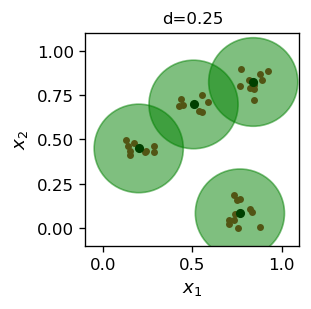

In [29]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.title("d="+str(d),fontsize=10) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
    
# drawing the circles
for k in range(len(R)):
    circ=plt.Circle((R[k][0],R[k][1]), radius=d, color='green', fill=True, alpha=0.5)
    plt.gca().add_artist(circ)
     
plt.scatter(alls[:,0],alls[:,1],c='brown', s=10)

for k in range(len(R)):
    plt.scatter(R[k][0],R[k][1],c='black', s=20)

plt.xlabel('$x_1$',fontsize=11)
plt.ylabel('$x_2$',fontsize=11)
plt.show()

We can promptly see that the dot product maximization algorithm yields an almost exactly the same result as the distance squared minimization (cf. {numref}`dyn-fig`.

## Exercises

```{admonition} $~$
:class: warning

1. The city (Manhattan) metric is defined as
$ d (\vec {x}, \vec {y}) = | x_1-y_1 | + | x_2 - y_2 | $ for points $ \vec {x} $ and $ \vec {y} $.
Repeat the simulations of this chapter using this metric. Draw conclusions.

2. Run the classification algorithms for more categories in the data sample (generate your own sample). 

3. Extend the dynamic clusterization algorithm to a three-dimensional input space.  
```